In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.1 MB/s eta 0:00:00:00:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.0 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import random
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import warnings
warnings.filterwarnings('ignore')

In [3]:

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Constants and Configuration
MELANOMA_CLASS_NAMES = [
    "Melanocytic Nevus",     # label 0
    "Melanoma",              # label 1  
    "Benign Keratosis",      # label 2
    "Basal Cell Carcinoma",  # label 3
    "Actinic Keratoses",     # label 4
    "Vascular Lesion",       # label 5
    "Dermatofibroma"         # label 6
]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Data Transforms
TRAIN_TRANSFORM_224 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

TRAIN_TRANSFORM_299 = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.RandomCrop((299, 299)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

VAL_TRANSFORM_224 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

VAL_TRANSFORM_299 = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [5]:
# Data Loading Function
def load_files():
    """Load HAM10000 dataset"""
    TEST_META = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'
    IMG_DIRS = [
        '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1',
        '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'
    ]
    
    df = pd.read_csv(TEST_META)
    df['image_id'] = df['image_id'] + '.jpg'
    
    image_paths = {}
    for d in IMG_DIRS:
        for fname in os.listdir(d):
            image_paths[fname] = os.path.join(d, fname)
            
    df['image_path'] = df['image_id'].map(image_paths)
    df = df.dropna(subset=['image_path'])
    
    label_names = sorted(np.unique(df['dx']))
    label_map = {name: idx for idx, name in enumerate(label_names)}
    df['label'] = df['dx'].map(label_map)
    
    return df, image_paths, label_names

In [6]:
# Custom Dataset Class
class SkinLesionDataset(Dataset):
    def __init__(self, df, transform=None, augment_minority_classes=False):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.augment_minority_classes = augment_minority_classes
        
        if augment_minority_classes:
            self.df = self._augment_minority_classes()

    def _augment_minority_classes(self):
        class_counts = self.df['label'].value_counts()
        minority_threshold = 1000
        minority_classes = class_counts[class_counts < minority_threshold].index
        
        augmented_df = self.df.copy()
        
        for class_label in minority_classes:
            class_samples = self.df[self.df['label'] == class_label]
            replications_needed = minority_threshold // len(class_samples)
            for _ in range(replications_needed - 1):
                augmented_df = pd.concat([augmented_df, class_samples], ignore_index=True)
                
        return augmented_df.sample(frac=1, random_state=42).reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            row = self.df.iloc[idx]
            image = Image.open(row['image_path']).convert('RGB')
            label = int(row['label'])
            
            if self.transform:
                image = self.transform(image)
            
            return image, label
        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
            if self.transform:
                black_image = self.transform(Image.new('RGB', (224, 224), (0, 0, 0)))
            else:
                black_image = Image.new('RGB', (224, 224), (0, 0, 0))
            return black_image, 0

In [7]:
# Model Architectures
class ImprovedResNet50(nn.Module):
    def __init__(self, num_classes, pretrained=True, dropout_rate=0.5):
        super().__init__()
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.6),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

In [8]:
class ImprovedEfficientNetB0(nn.Module):
    def __init__(self, num_classes, pretrained=True, dropout_rate=0.5):
        super().__init__()
        self.backbone = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT if pretrained else None)
        num_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.6),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

In [9]:
class ImprovedInceptionV3(nn.Module):
    def __init__(self, num_classes, pretrained=True, dropout_rate=0.5):
        super().__init__()
        self.backbone = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT if pretrained else None)
        self.backbone.aux_logits = False
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.6),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

In [10]:
# Training Function
def train_model(model, train_loader, val_loader, num_epochs=5, model_name="model"):
    print(f"Starting training for {model_name}")
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Validation samples: {len(val_loader.dataset)}")
    
    # Calculate class weights
    y_train = [train_loader.dataset.df.iloc[i]['label'] for i in range(len(train_loader.dataset))]
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights = torch.FloatTensor(class_weights).to(device)
    
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=7, verbose=True, min_lr=1e-7
    )
    
    best_val_acc = 0.0
    patience_counter = 0
    patience = 15
    train_losses, val_losses, val_accuracies = [], [], []
    
    print(f"Training {model_name}...")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch_idx, (inputs, labels) in enumerate(train_bar):
            inputs, labels = inputs.to(device), labels.to(device)
            
            if inputs.size(0) == 1:
                continue
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            train_bar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{100.*train_correct/train_total:.2f}%'
            })
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                val_bar.set_postfix({
                    'Loss': f'{val_loss/(len(val_bar)+1):.4f}',
                    'Acc': f'{100.*val_correct/val_total:.2f}%'
                })
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)
        
        scheduler.step(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'improved_{model_name.lower()}_skin.pth')
            patience_counter = 0
            print(f'New best validation accuracy: {val_acc:.2f}%. Model saved!')
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break
    
    return train_losses, val_losses, val_accuracies, best_val_acc

# DataLoader creation
def create_dataloader(dataset, batch_size, shuffle=True, num_workers=2):
    return DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True
    )


In [11]:
def train_and_save_improved_models():
    """Complete training pipeline for all three models"""
    
    # Load data
    df, image_paths, label_names = load_files()
    
    # Print dataset information
    print(f"Total samples: {len(df)}")
    print("\nClass distribution:")
    class_counts = df['label'].value_counts().sort_index()
    for i, count in enumerate(class_counts):
        print(f"{i}: {MELANOMA_CLASS_NAMES[i]}: {count} samples")
    
    # Prepare data splits
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
    train_df, test_df = train_test_split(train_df, test_size=0.1, stratify=train_df['label'], random_state=42)
    
    print(f"\nTraining set size: {len(train_df)}")
    print(f"Validation set size: {len(val_df)}")
    print(f"Test set size: {len(test_df)}")
    
    num_classes = 7
    batch_size = 16

    models_to_train = [
        {
            'name': 'ResNet50',
            'model_class': ImprovedResNet50,
            'train_transform': TRAIN_TRANSFORM_224,
            'val_transform': VAL_TRANSFORM_224
        },
        {
            'name': 'EfficientNetB0',
            'model_class': ImprovedEfficientNetB0,
            'train_transform': TRAIN_TRANSFORM_224,
            'val_transform': VAL_TRANSFORM_224
        },
        {
            'name': 'InceptionV3',
            'model_class': ImprovedInceptionV3,
            'train_transform': TRAIN_TRANSFORM_299,
            'val_transform': VAL_TRANSFORM_299
        }
    ]
    
    training_results = {}

    # Train each model
    for model_config in models_to_train:
        model_name = model_config['name']
        print(f"\n{'='*60}")
        print(f"Training {model_name}")
        print(f"{'='*60}")
        
        # Create datasets
        train_dataset = SkinLesionDataset(
            train_df, 
            transform=model_config['train_transform'],
            augment_minority_classes=True
        )
        val_dataset = SkinLesionDataset(
            val_df, 
            transform=model_config['val_transform']
        )
        
        # Create data loaders
        train_loader = create_dataloader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = create_dataloader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Initialize model
        model = model_config['model_class'](num_classes=num_classes)
        model = model.to(device)
        
        # Train model
        train_losses, val_losses, val_accuracies, best_val_acc = train_model(
            model, train_loader, val_loader, num_epochs=5, model_name=model_name
        )
        
        training_results[model_name] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'best_val_acc': best_val_acc
        }
        
        # Plot training curves
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.plot(train_losses, label='Train Loss', color='blue')
        plt.plot(val_losses, label='Val Loss', color='red')
        plt.title(f'{model_name} - Loss Curves')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 3, 2)
        plt.plot(val_accuracies, label='Val Accuracy', color='green', marker='o')
        plt.title(f'{model_name} - Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 3, 3)
        epochs = range(1, len(train_losses) + 1)
        plt.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
        plt.plot(epochs, val_losses, 'r-', label='Val Loss', linewidth=2)
        plt.title(f'{model_name} - Training Progress')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # Summary of results
    print(f"\n{'='*60}")
    print("TRAINING SUMMARY")
    print(f"{'='*60}")
    for model_name, results in training_results.items():
        print(f"{model_name}: Best Val Accuracy = {results['best_val_acc']:.2f}%")
    
    # Save test dataframe for later use
    test_df.to_csv('test_data.csv', index=False)
    
    return training_results, test_df

In [13]:
# Model Loading Functions
models_dict = None

def load_improved_models(num_classes):
    global models_dict
    if models_dict is not None:
        print("Models already loaded, using cached versions.")
        return models_dict
        
    print("Loading improved models...")
    mdict = {}
    
    model_configs = [
        ('ResNet50', ImprovedResNet50, 'improved_resnet50_skin.pth'),
        ('EfficientNetB0', ImprovedEfficientNetB0, 'improved_efficientnetb0_skin.pth'),
        ('InceptionV3', ImprovedInceptionV3, 'improved_inceptionv3_skin.pth')
    ]
    
    for model_name, model_class, filename in model_configs:
        if os.path.exists(filename):
            print(f"Loading {model_name}...")
            model = model_class(num_classes=num_classes)
            model.load_state_dict(torch.load(filename, map_location=device))
            model = model.to(device)
            model.eval()
            mdict[model_name] = model
            print(f"{model_name} loaded successfully!")
        else:
            print(f"Warning: {filename} not found. Train the model first.")
    
    models_dict = mdict
    return mdict

In [14]:
def get_improved_models():
    global models_dict
    if models_dict is None:
        models_dict = load_improved_models(num_classes=7)
    return models_dict

# Utility Functions for Testing
def get_target_layer(model_name, model):
    if model_name == "ResNet50":
        return model.backbone.layer4[-1]
    elif model_name == "EfficientNetB0":
        return model.backbone.features[-1]
    elif model_name == "InceptionV3":
        return model.backbone.Mixed_7c

def get_val_transform(model_name):
    if model_name == "InceptionV3":
        return VAL_TRANSFORM_299
    else:
        return VAL_TRANSFORM_224

def ensemble_predict(models_dict, input_tensor, model_names=None):
    if model_names is None:
        model_names = list(models_dict.keys())
    
    predictions = []
    individual_preds = {}
    
    for model_name in model_names:
        if model_name in models_dict:
            model = models_dict[model_name]
            model.eval()
            with torch.no_grad():
                output = model(input_tensor)
                prob = torch.softmax(output, dim=1)
                predictions.append(prob)
                individual_preds[model_name] = prob.cpu().numpy()[0]
    
    if predictions:
        ensemble_pred = torch.mean(torch.stack(predictions), dim=0)
        return ensemble_pred.cpu().numpy()[0], individual_preds
    else:
        return None, {}

def generate_gradcam_visualization(model, model_name, input_tensor, pred_class_idx, original_image):
    try:
        target_layer = get_target_layer(model_name, model)
        cam = GradCAM(model=model, target_layers=[target_layer])
        targets = [ClassifierOutputTarget(pred_class_idx)]
        
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
        
        transform_size = get_val_transform(model_name).transforms[0].size
        if isinstance(transform_size, int):
            rgb_img = np.array(original_image.resize((transform_size, transform_size))).astype(np.float32) / 255.0
        else:
            rgb_img = np.array(original_image.resize(transform_size)).astype(np.float32) / 255.0
        
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        
        return rgb_img, visualization, grayscale_cam
    except Exception as e:
        print(f"Error generating Grad-CAM for {model_name}: {e}")
        return None, None, None

In [16]:
def plot_gradcam_comparison(original_images, gradcam_visualizations, model_names, image_name, predictions, ground_truth):
    n_models = len(model_names)
    if n_models == 0:
        return
    
    fig, axes = plt.subplots(2, n_models + 1, figsize=(4 * (n_models + 1), 8))
    
    if axes.ndim == 1:
        axes = axes.reshape(1, -1)
    
    # Original image display
    if len(original_images) > 0:
        axes[0, 0].imshow(original_images[0])
        axes[0, 0].set_title(f"Original\n{image_name}")
        axes[0, 0].axis('off')
        
        axes[1, 0].text(0.5, 0.5, f"Ground Truth:\n{ground_truth}", 
                       ha='center', va='center', fontsize=12, weight='bold',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
        axes[1, 0].axis('off')
    
    # Grad-CAM visualizations
    for i, model_name in enumerate(model_names):
        col_idx = i + 1
        
        if i < len(gradcam_visualizations) and gradcam_visualizations[i] is not None:
            axes[0, col_idx].imshow(gradcam_visualizations[i])
            
            pred_info = predictions.get(model_name, {})
            pred_name = MELANOMA_CLASS_NAMES[pred_info.get('prediction', 0)] if pred_info.get('prediction', 0) < len(MELANOMA_CLASS_NAMES) else "Unknown"
            confidence = pred_info.get('confidence', 0)
            status = "✓" if pred_info.get('correct', False) else "✗"
            
            axes[0, col_idx].set_title(f"{model_name}\nGrad-CAM {status}")
            axes[0, col_idx].axis('off')

            color = "lightgreen" if pred_info.get('correct', False) else "lightcoral"
            axes[1, col_idx].text(0.5, 0.5, f"Prediction:\n{pred_name}\nConfidence: {confidence:.3f}", 
                                 ha='center', va='center', fontsize=10,
                                 bbox=dict(boxstyle="round,pad=0.3", facecolor=color))
            axes[1, col_idx].axis('off')
        else:
            axes[0, col_idx].text(0.5, 0.5, f"Grad-CAM\nError", ha='center', va='center')
            axes[0, col_idx].axis('off')
            axes[1, col_idx].axis('off')
    
    plt.tight_layout()
    plt.show()

In [18]:
# Comprehensive Testing Function
def comprehensive_model_evaluation(test_df=None, num_random_images=10, show_gradcam=True):
    """Comprehensive evaluation with detailed metrics and comparisons"""
    
    # Load models
    models_dict = get_improved_models()
    if not models_dict:
        print("No models found. Please train them first.")
        return
    
    # Load test data
    if test_df is None:
        if os.path.exists('test_data.csv'):
            test_df = pd.read_csv('test_data.csv')
        else:
            df, _, _ = load_files()
            test_df = df.sample(n=min(1000, len(df)), random_state=42)
    
    print(f"\n{'='*80}")
    print(f"COMPREHENSIVE MODEL EVALUATION")
    print(f"{'='*80}")
    print(f"Total test samples: {len(test_df)}")
    print(f"Random visualization samples: {num_random_images}")
    
    # Initialize result storage
    all_predictions = {model_name: [] for model_name in models_dict.keys()}
    all_ground_truth = []
    all_confidences = {model_name: [] for model_name in models_dict.keys()}
    ensemble_predictions = []
    ensemble_confidences = []
    
    # Test on subset for detailed analysis
    random_indices = random.sample(range(len(test_df)), min(num_random_images, len(test_df)))
    detailed_results = []
    
    print(f"\n{'-'*40}")
    print("DETAILED ANALYSIS ON RANDOM SAMPLES")
    print(f"{'-'*40}")
    
    for idx, test_idx in enumerate(random_indices):
        row = test_df.iloc[test_idx]
        img_path = row['image_path']
        gt_label = int(row['label'])
        gt_name = MELANOMA_CLASS_NAMES[gt_label]
        
        print(f"\nImage {idx+1}/{len(random_indices)}: {os.path.basename(img_path)}")
        print(f"Ground Truth: {gt_name}")
        print("-" * 30)
        
        # Load image
        pil_img = Image.open(img_path).convert('RGB')
        
        # Storage for visualization
        individual_predictions = {}
        gradcam_visualizations = []
        original_images = []
        model_names_for_viz = []
        
        # Test each model
        sample_results = {'ground_truth': gt_label, 'image_path': img_path}
        
        for model_name in models_dict.keys():
            model = models_dict[model_name]
            val_transform = get_val_transform(model_name)
            
            input_tensor = val_transform(pil_img).unsqueeze(0).to(device)
            
            with torch.no_grad():
                outputs = model(input_tensor)
                probabilities = torch.softmax(outputs, dim=1)
                pred_class_idx = int(torch.argmax(probabilities, 1).cpu().numpy()[0])
                confidence = float(probabilities[0][pred_class_idx].cpu().numpy())
            
            pred_name = MELANOMA_CLASS_NAMES[pred_class_idx]
            is_correct = pred_class_idx == gt_label
            status = "✓ CORRECT" if is_correct else "✗ WRONG"
            
            print(f"{model_name:15}: {pred_name:20} ({confidence:.3f}) {status}")
            
            # Store results
            individual_predictions[model_name] = {
                'prediction': pred_class_idx,
                'confidence': confidence,
                'correct': is_correct
            }
            
            sample_results[f'{model_name}_pred'] = pred_class_idx
            sample_results[f'{model_name}_conf'] = confidence
            sample_results[f'{model_name}_correct'] = is_correct
            
            # Generate Grad-CAM
            if show_gradcam:
                rgb_img, gradcam_viz, _ = generate_gradcam_visualization(
                    model, model_name, input_tensor, pred_class_idx, pil_img
                )
                
                if gradcam_viz is not None:
                    gradcam_visualizations.append(gradcam_viz)
                    if len(original_images) == 0:
                        original_images.append(rgb_img)
                    model_names_for_viz.append(model_name)
        
        # Ensemble prediction
        input_tensor_ensemble = VAL_TRANSFORM_224(pil_img).unsqueeze(0).to(device)
        ensemble_pred, _ = ensemble_predict(models_dict, input_tensor_ensemble)
        
        if ensemble_pred is not None:
            ensemble_class_idx = int(np.argmax(ensemble_pred))
            ensemble_confidence = float(ensemble_pred[ensemble_class_idx])
            ensemble_name = MELANOMA_CLASS_NAMES[ensemble_class_idx]
            ensemble_correct = ensemble_class_idx == gt_label
            ensemble_status = "✓ CORRECT" if ensemble_correct else "✗ WRONG"
            
            print(f"{'Ensemble':15}: {ensemble_name:20} ({ensemble_confidence:.3f}) {ensemble_status}")
            
            sample_results['ensemble_pred'] = ensemble_class_idx
            sample_results['ensemble_conf'] = ensemble_confidence
            sample_results['ensemble_correct'] = ensemble_correct
        
        detailed_results.append(sample_results)
        
        # Display Grad-CAM visualizations
        if show_gradcam and gradcam_visualizations:
            plot_gradcam_comparison(
                original_images, gradcam_visualizations, model_names_for_viz,
                os.path.basename(img_path), individual_predictions, gt_name
            )
    
    # Comprehensive evaluation on full test set
    print(f"\n{'-'*40}")
    print("COMPREHENSIVE EVALUATION ON FULL TEST SET")
    print(f"{'-'*40}")
    
    for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Evaluating"):
        try:
            img_path = row['image_path']
            gt_label = int(row['label'])
            pil_img = Image.open(img_path).convert('RGB')
            
            all_ground_truth.append(gt_label)
            
            # Test each model
            for model_name in models_dict.keys():
                model = models_dict[model_name]
                val_transform = get_val_transform(model_name)
                
                input_tensor = val_transform(pil_img).unsqueeze(0).to(device)
                
                with torch.no_grad():
                    outputs = model(input_tensor)
                    probabilities = torch.softmax(outputs, dim=1)
                    pred_class_idx = int(torch.argmax(probabilities, 1).cpu().numpy()[0])
                    confidence = float(probabilities[0][pred_class_idx].cpu().numpy())
                
                all_predictions[model_name].append(pred_class_idx)
                all_confidences[model_name].append(confidence)
            
            # Ensemble prediction
            input_tensor_ensemble = VAL_TRANSFORM_224(pil_img).unsqueeze(0).to(device)
            ensemble_pred, _ = ensemble_predict(models_dict, input_tensor_ensemble)
            
            if ensemble_pred is not None:
                ensemble_class_idx = int(np.argmax(ensemble_pred))
                ensemble_confidence = float(ensemble_pred[ensemble_class_idx])
                ensemble_predictions.append(ensemble_class_idx)
                ensemble_confidences.append(ensemble_confidence)
            
        except Exception as e:
            print(f"Error processing image {idx}: {e}")
            continue
    
    # Calculate comprehensive metrics
    print(f"\n{'='*80}")
    print("COMPREHENSIVE PERFORMANCE METRICS")
    print(f"{'='*80}")
    
    results_summary = {}
    
    # Individual model metrics
    for model_name in models_dict.keys():
        if len(all_predictions[model_name]) > 0:
            accuracy = np.mean(np.array(all_predictions[model_name]) == np.array(all_ground_truth)) * 100
            precision = precision_score(all_ground_truth, all_predictions[model_name], average='weighted') * 100
            recall = recall_score(all_ground_truth, all_predictions[model_name], average='weighted') * 100
            f1 = f1_score(all_ground_truth, all_predictions[model_name], average='weighted') * 100
            avg_confidence = np.mean(all_confidences[model_name]) * 100
            
            results_summary[model_name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'avg_confidence': avg_confidence
            }
            
            print(f"\n{model_name} Performance:")
            print(f"  Accuracy:     {accuracy:.2f}%")
            print(f"  Precision:    {precision:.2f}%")
            print(f"  Recall:       {recall:.2f}%")
            print(f"  F1-Score:     {f1:.2f}%")
            print(f"  Avg Conf:     {avg_confidence:.2f}%")
    
    # Ensemble metrics
    if len(ensemble_predictions) > 0:
        ensemble_accuracy = np.mean(np.array(ensemble_predictions) == np.array(all_ground_truth)) * 100
        ensemble_precision = precision_score(all_ground_truth, ensemble_predictions, average='weighted') * 100
        ensemble_recall = recall_score(all_ground_truth, ensemble_predictions, average='weighted') * 100
        ensemble_f1 = f1_score(all_ground_truth, ensemble_predictions, average='weighted') * 100
        ensemble_avg_confidence = np.mean(ensemble_confidences) * 100
        
        results_summary['Ensemble'] = {
            'accuracy': ensemble_accuracy,
            'precision': ensemble_precision,
            'recall': ensemble_recall,
            'f1_score': ensemble_f1,
            'avg_confidence': ensemble_avg_confidence
        }
        
        print(f"\nEnsemble Performance:")
        print(f"  Accuracy:     {ensemble_accuracy:.2f}%")
        print(f"  Precision:    {ensemble_precision:.2f}%")
        print(f"  Recall:       {ensemble_recall:.2f}%")
        print(f"  F1-Score:     {ensemble_f1:.2f}%")
        print(f"  Avg Conf:     {ensemble_avg_confidence:.2f}%")
    
    # Performance comparison visualization
    plt.figure(figsize=(20, 12))
    
    # Accuracy comparison
    plt.subplot(2, 3, 1)
    models = list(results_summary.keys())
    accuracies = [results_summary[m]['accuracy'] for m in models]
    colors = plt.cm.Set3(np.linspace(0, 1, len(models)))
    
    bars = plt.bar(models, accuracies, color=colors)
    plt.title('Model Accuracy Comparison', fontsize=14, weight='bold')
    plt.ylabel('Accuracy (%)')
    plt.xticks(rotation=45)
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.grid(True, alpha=0.3)
    
    # F1-Score comparison
    plt.subplot(2, 3, 2)
    f1_scores = [results_summary[m]['f1_score'] for m in models]
    bars = plt.bar(models, f1_scores, color=colors)
    plt.title('Model F1-Score Comparison', fontsize=14, weight='bold')
    plt.ylabel('F1-Score (%)')
    plt.xticks(rotation=45)
    
    for bar, f1 in zip(bars, f1_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{f1:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.grid(True, alpha=0.3)
    
    # Precision vs Recall
    plt.subplot(2, 3, 3)
    precisions = [results_summary[m]['precision'] for m in models]
    recalls = [results_summary[m]['recall'] for m in models]
    
    for i, model in enumerate(models):
        plt.scatter(recalls[i], precisions[i], s=200, c=[colors[i]], 
                   label=model, alpha=0.7, edgecolors='black')
        plt.annotate(model, (recalls[i], precisions[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=10)
    
    plt.title('Precision vs Recall', fontsize=14, weight='bold')
    plt.xlabel('Recall (%)')
    plt.ylabel('Precision (%)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Confidence distribution
    plt.subplot(2, 3, 4)
    conf_data = []
    conf_labels = []
    for model_name in models_dict.keys():
        if len(all_confidences[model_name]) > 0:
            conf_data.append(np.array(all_confidences[model_name]) * 100)
            conf_labels.append(model_name)
    
    if ensemble_confidences:
        conf_data.append(np.array(ensemble_confidences) * 100)
        conf_labels.append('Ensemble')
    
    plt.boxplot(conf_data, labels=conf_labels)
    plt.title('Confidence Distribution', fontsize=14, weight='bold')
    plt.ylabel('Confidence (%)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Overall metrics radar chart
    plt.subplot(2, 3, 5)
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle
    
    for i, model in enumerate(models):
        values = [
            results_summary[model]['accuracy'],
            results_summary[model]['precision'], 
            results_summary[model]['recall'],
            results_summary[model]['f1_score']
        ]
        values += values[:1]  # Complete the circle
        
        plt.plot(angles, values, 'o-', linewidth=2, label=model, color=colors[i])
        plt.fill(angles, values, alpha=0.1, color=colors[i])
    
    plt.xticks(angles[:-1], metrics)
    plt.ylim(0, 100)
    plt.title('Overall Performance Radar', fontsize=14, weight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Class-wise performance heatmap
    plt.subplot(2, 3, 6)
    
    # Create confusion matrix for best performing model
    best_model = max(results_summary.keys(), key=lambda x: results_summary[x]['accuracy'])
    if best_model == 'Ensemble':
        cm = confusion_matrix(all_ground_truth, ensemble_predictions)
    else:
        cm = confusion_matrix(all_ground_truth, all_predictions[best_model])
    
    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='Blues',
                xticklabels=[name[:15] for name in MELANOMA_CLASS_NAMES],
                yticklabels=[name[:15] for name in MELANOMA_CLASS_NAMES])
    plt.title(f'Confusion Matrix - {best_model}', fontsize=14, weight='bold')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    plt.tight_layout()
    plt.show()
    
    # Detailed classification report
    print(f"\n{'='*80}")
    print(f"DETAILED CLASSIFICATION REPORT - BEST MODEL ({best_model})")
    print(f"{'='*80}")
    
    if best_model == 'Ensemble':
        report = classification_report(all_ground_truth, ensemble_predictions, 
                                     target_names=MELANOMA_CLASS_NAMES, digits=3)
    else:
        report = classification_report(all_ground_truth, all_predictions[best_model], 
                                     target_names=MELANOMA_CLASS_NAMES, digits=3)
    print(report)
    
    # Summary table
    print(f"\n{'='*80}")
    print("FINAL PERFORMANCE SUMMARY")
    print(f"{'='*80}")
    print(f"{'Model':<15} {'Accuracy':<10} {'Precision':<11} {'Recall':<8} {'F1-Score':<9} {'Avg Conf':<9}")
    print("-" * 80)
    
    for model_name, metrics in results_summary.items():
        print(f"{model_name:<15} {metrics['accuracy']:<10.2f} {metrics['precision']:<11.2f} "
              f"{metrics['recall']:<8.2f} {metrics['f1_score']:<9.2f} {metrics['avg_confidence']:<9.2f}")
    
    print(f"\nBest performing model: {best_model} with {results_summary[best_model]['accuracy']:.2f}% accuracy")
    
    return results_summary, detailed_results


Starting complete SkinScanAI evaluation pipeline...
Step 1: Training models for 5 epochs...
Total samples: 10015

Class distribution:
0: Melanocytic Nevus: 327 samples
1: Melanoma: 514 samples
2: Benign Keratosis: 1099 samples
3: Basal Cell Carcinoma: 115 samples
4: Actinic Keratoses: 1113 samples
5: Vascular Lesion: 6705 samples
6: Dermatofibroma: 142 samples

Training set size: 7210
Validation set size: 2003
Test set size: 802

Training ResNet50


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 211MB/s]


Starting training for ResNet50
Training samples: 10017
Validation samples: 2003
Training ResNet50...


Epoch 1/5 [Val]: 100%|██████████| 125/125 [00:18<00:00,  6.63it/s, Loss=0.8394, Acc=69.25%]


Epoch 1/5:
Train Loss: 1.0800, Train Acc: 62.21%
Val Loss: 0.8461, Val Acc: 69.25%
--------------------------------------------------
New best validation accuracy: 69.25%. Model saved!


Epoch 2/5 [Val]: 100%|██████████| 125/125 [00:11<00:00, 11.03it/s, Loss=0.7743, Acc=76.35%]


Epoch 2/5:
Train Loss: 0.7006, Train Acc: 74.21%
Val Loss: 0.7805, Val Acc: 76.35%
--------------------------------------------------
New best validation accuracy: 76.35%. Model saved!


Epoch 3/5 [Val]: 100%|██████████| 125/125 [00:10<00:00, 11.45it/s, Loss=0.8301, Acc=76.50%]


Epoch 3/5:
Train Loss: 0.5688, Train Acc: 78.14%
Val Loss: 0.8367, Val Acc: 76.50%
--------------------------------------------------
New best validation accuracy: 76.50%. Model saved!


Epoch 4/5 [Val]: 100%|██████████| 125/125 [00:11<00:00, 11.28it/s, Loss=0.8289, Acc=81.20%]


Epoch 4/5:
Train Loss: 0.5140, Train Acc: 80.51%
Val Loss: 0.8355, Val Acc: 81.20%
--------------------------------------------------
New best validation accuracy: 81.20%. Model saved!


Epoch 5/5 [Val]: 100%|██████████| 125/125 [00:10<00:00, 11.40it/s, Loss=0.9255, Acc=81.00%]


Epoch 5/5:
Train Loss: 0.4598, Train Acc: 82.80%
Val Loss: 0.9329, Val Acc: 81.00%
--------------------------------------------------


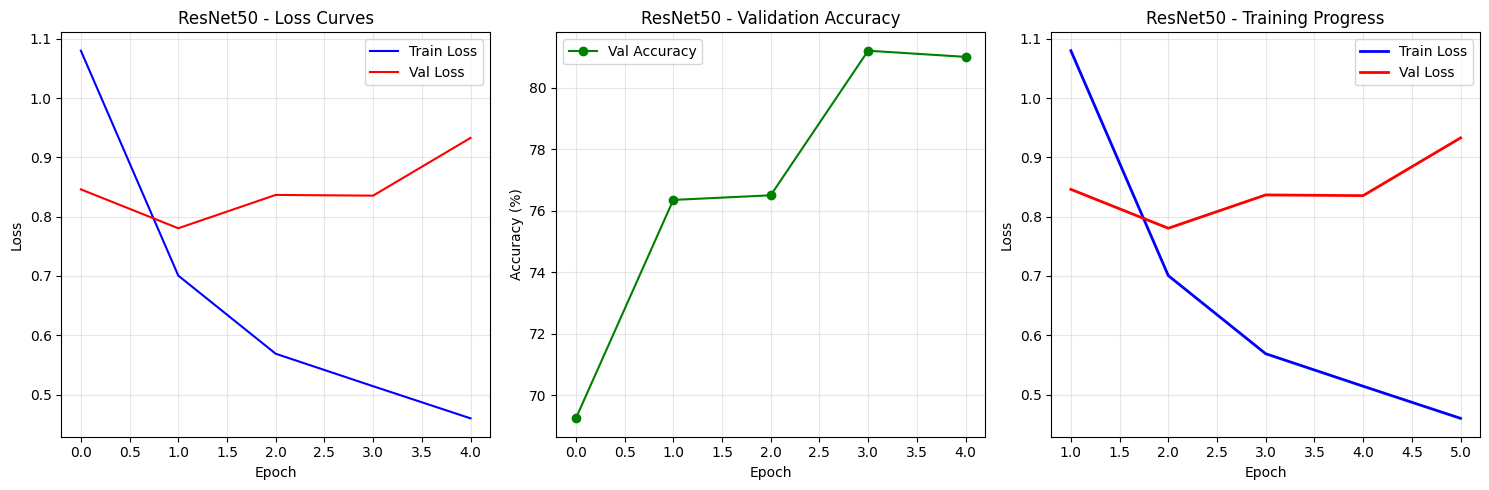

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth



Training EfficientNetB0


100%|██████████| 20.5M/20.5M [00:00<00:00, 159MB/s]


Starting training for EfficientNetB0
Training samples: 10017
Validation samples: 2003
Training EfficientNetB0...


Epoch 1/5 [Val]: 100%|██████████| 125/125 [00:10<00:00, 11.73it/s, Loss=0.8930, Acc=69.05%]


Epoch 1/5:
Train Loss: 1.1640, Train Acc: 59.13%
Val Loss: 0.9002, Val Acc: 69.05%
--------------------------------------------------
New best validation accuracy: 69.05%. Model saved!


Epoch 2/5 [Val]: 100%|██████████| 125/125 [00:11<00:00, 11.30it/s, Loss=0.8302, Acc=71.55%]


Epoch 2/5:
Train Loss: 0.7103, Train Acc: 73.39%
Val Loss: 0.8368, Val Acc: 71.55%
--------------------------------------------------
New best validation accuracy: 71.55%. Model saved!


Epoch 3/5 [Val]: 100%|██████████| 125/125 [00:10<00:00, 11.78it/s, Loss=0.7539, Acc=78.75%]


Epoch 3/5:
Train Loss: 0.5926, Train Acc: 76.69%
Val Loss: 0.7599, Val Acc: 78.75%
--------------------------------------------------
New best validation accuracy: 78.75%. Model saved!


Epoch 4/5 [Val]: 100%|██████████| 125/125 [00:10<00:00, 12.10it/s, Loss=0.7016, Acc=78.50%]


Epoch 4/5:
Train Loss: 0.5251, Train Acc: 79.58%
Val Loss: 0.7072, Val Acc: 78.50%
--------------------------------------------------


Epoch 5/5 [Val]: 100%|██████████| 125/125 [00:10<00:00, 11.77it/s, Loss=0.6709, Acc=81.95%]


Epoch 5/5:
Train Loss: 0.4631, Train Acc: 81.23%
Val Loss: 0.6763, Val Acc: 81.95%
--------------------------------------------------
New best validation accuracy: 81.95%. Model saved!


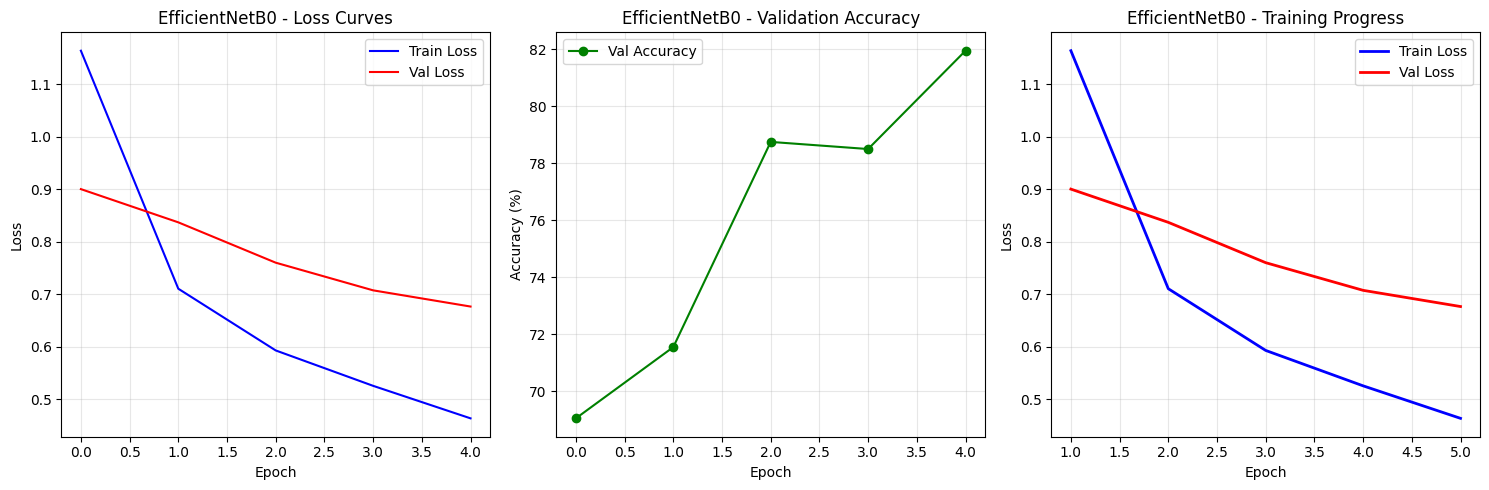


Training InceptionV3


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 213MB/s] 


Starting training for InceptionV3
Training samples: 10017
Validation samples: 2003
Training InceptionV3...


Epoch 1/5 [Val]: 100%|██████████| 125/125 [00:13<00:00,  9.40it/s, Loss=0.8999, Acc=74.95%]


Epoch 1/5:
Train Loss: 1.1087, Train Acc: 62.69%
Val Loss: 0.9071, Val Acc: 74.95%
--------------------------------------------------
New best validation accuracy: 74.95%. Model saved!


Epoch 2/5 [Val]: 100%|██████████| 125/125 [00:12<00:00,  9.74it/s, Loss=0.9717, Acc=72.90%]


Epoch 2/5:
Train Loss: 0.7020, Train Acc: 74.41%
Val Loss: 0.9795, Val Acc: 72.90%
--------------------------------------------------


Epoch 3/5 [Val]: 100%|██████████| 125/125 [00:13<00:00,  9.33it/s, Loss=0.7304, Acc=80.70%]


Epoch 3/5:
Train Loss: 0.5998, Train Acc: 77.38%
Val Loss: 0.7363, Val Acc: 80.70%
--------------------------------------------------
New best validation accuracy: 80.70%. Model saved!


Epoch 4/5 [Val]: 100%|██████████| 125/125 [00:12<00:00,  9.68it/s, Loss=0.7910, Acc=77.90%]


Epoch 4/5:
Train Loss: 0.5116, Train Acc: 81.45%
Val Loss: 0.7973, Val Acc: 77.90%
--------------------------------------------------


Epoch 5/5 [Val]: 100%|██████████| 125/125 [00:13<00:00,  9.32it/s, Loss=0.8751, Acc=81.30%]


Epoch 5/5:
Train Loss: 0.4661, Train Acc: 82.27%
Val Loss: 0.8822, Val Acc: 81.30%
--------------------------------------------------
New best validation accuracy: 81.30%. Model saved!


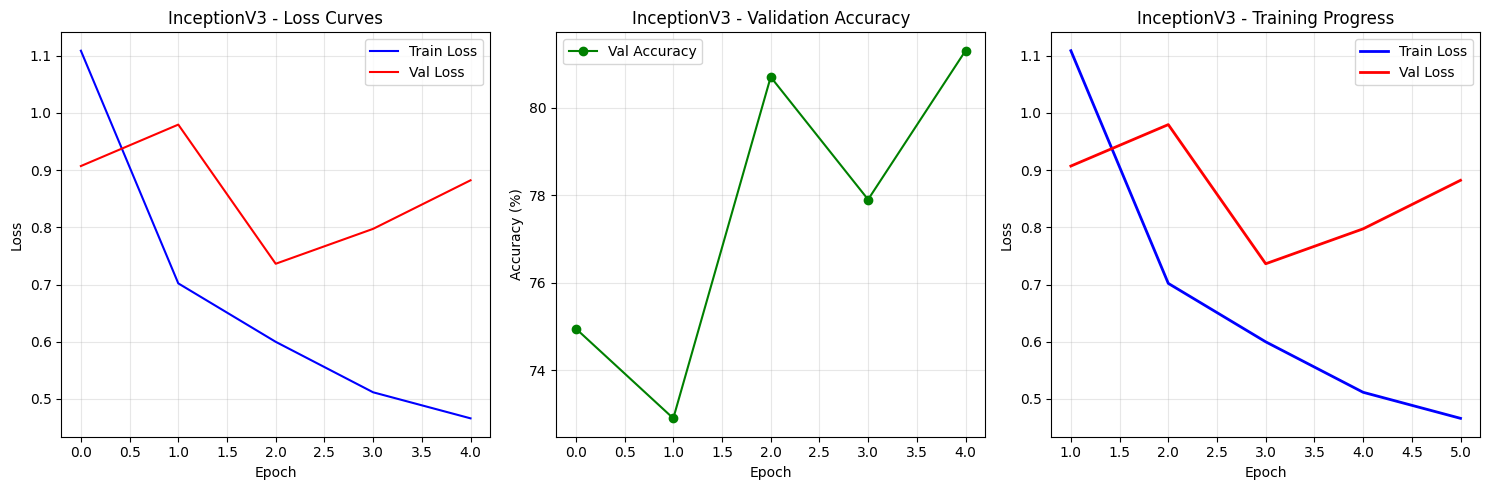


TRAINING SUMMARY
ResNet50: Best Val Accuracy = 81.20%
EfficientNetB0: Best Val Accuracy = 81.95%
InceptionV3: Best Val Accuracy = 81.30%

Step 2: Running comprehensive evaluation...
Loading improved models...
Loading ResNet50...
ResNet50 loaded successfully!
Loading EfficientNetB0...
EfficientNetB0 loaded successfully!
Loading InceptionV3...
InceptionV3 loaded successfully!

COMPREHENSIVE MODEL EVALUATION
Total test samples: 802
Random visualization samples: 10

----------------------------------------
DETAILED ANALYSIS ON RANDOM SAMPLES
----------------------------------------

Image 1/10: ISIC_0025896.jpg
Ground Truth: Vascular Lesion
------------------------------
ResNet50       : Vascular Lesion      (1.000) ✓ CORRECT
EfficientNetB0 : Vascular Lesion      (1.000) ✓ CORRECT
InceptionV3    : Vascular Lesion      (1.000) ✓ CORRECT
Ensemble       : Vascular Lesion      (0.994) ✓ CORRECT


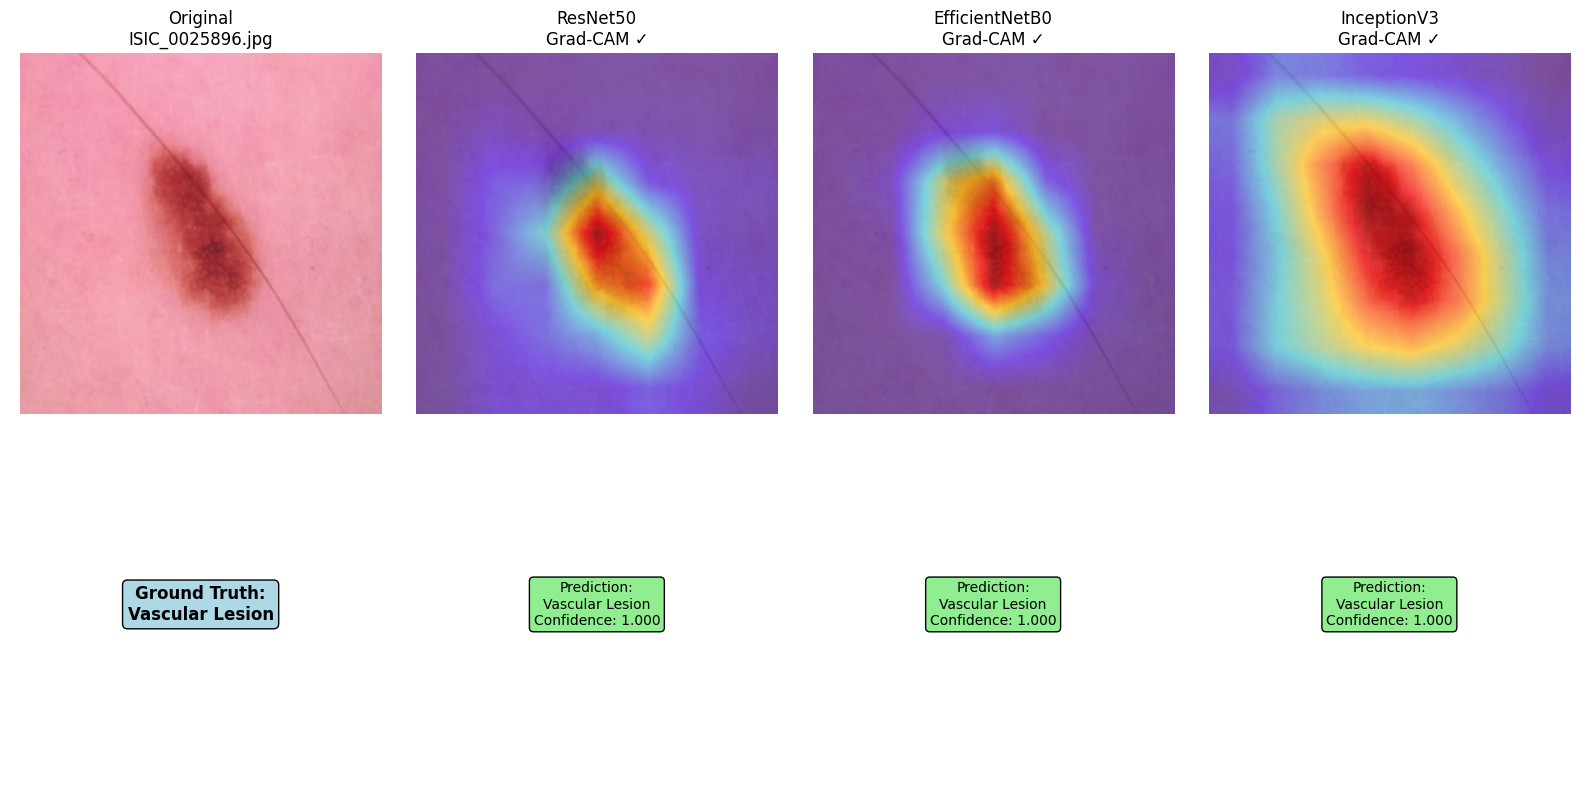


Image 2/10: ISIC_0029243.jpg
Ground Truth: Benign Keratosis
------------------------------
ResNet50       : Benign Keratosis     (0.816) ✓ CORRECT
EfficientNetB0 : Benign Keratosis     (0.995) ✓ CORRECT
InceptionV3    : Benign Keratosis     (0.891) ✓ CORRECT
Ensemble       : Benign Keratosis     (0.777) ✓ CORRECT


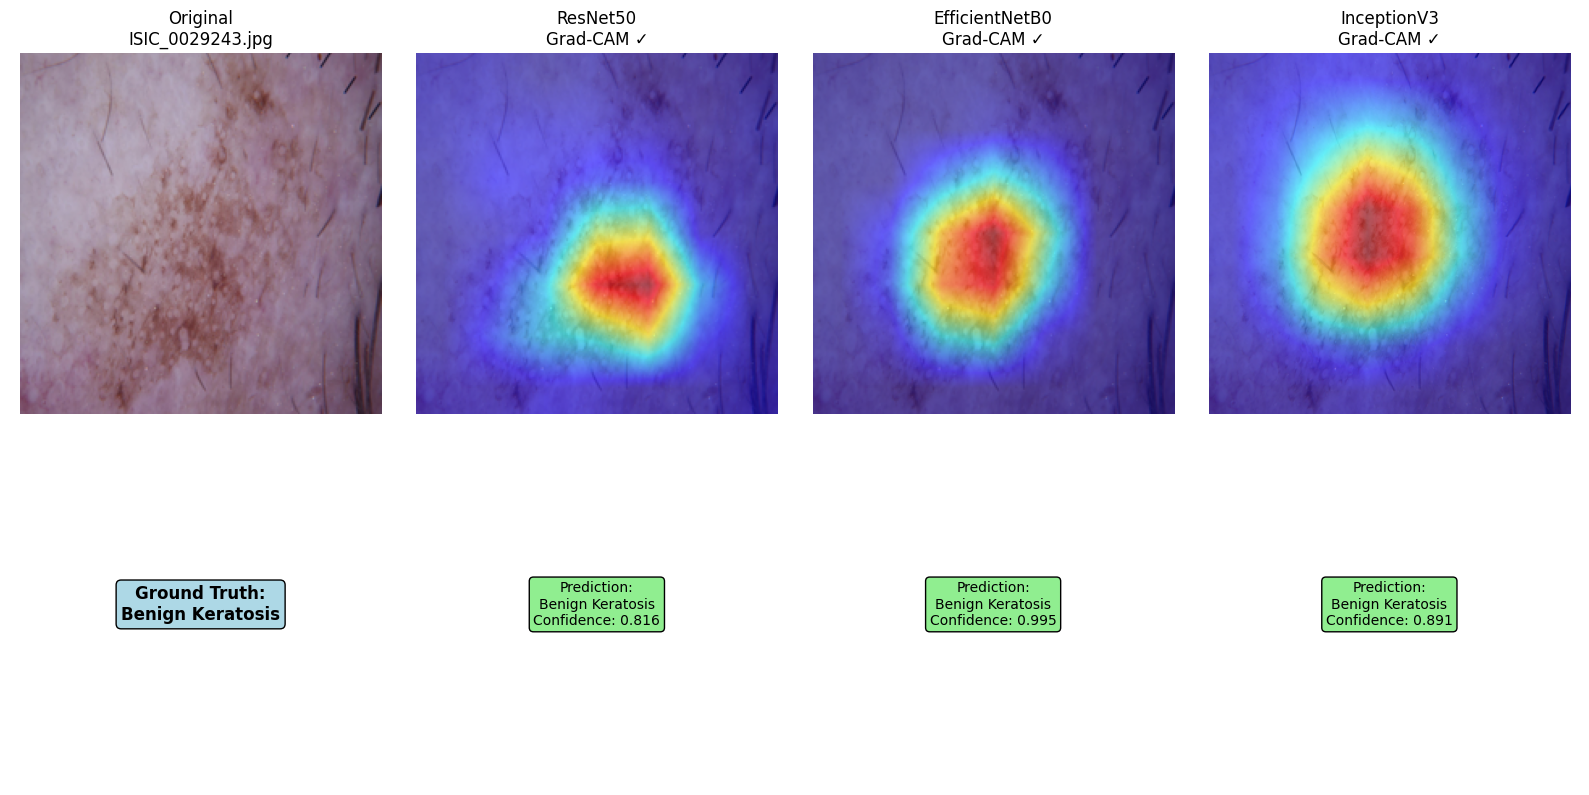


Image 3/10: ISIC_0033933.jpg
Ground Truth: Vascular Lesion
------------------------------
ResNet50       : Vascular Lesion      (0.699) ✓ CORRECT
EfficientNetB0 : Vascular Lesion      (0.803) ✓ CORRECT
InceptionV3    : Vascular Lesion      (0.937) ✓ CORRECT
Ensemble       : Vascular Lesion      (0.759) ✓ CORRECT


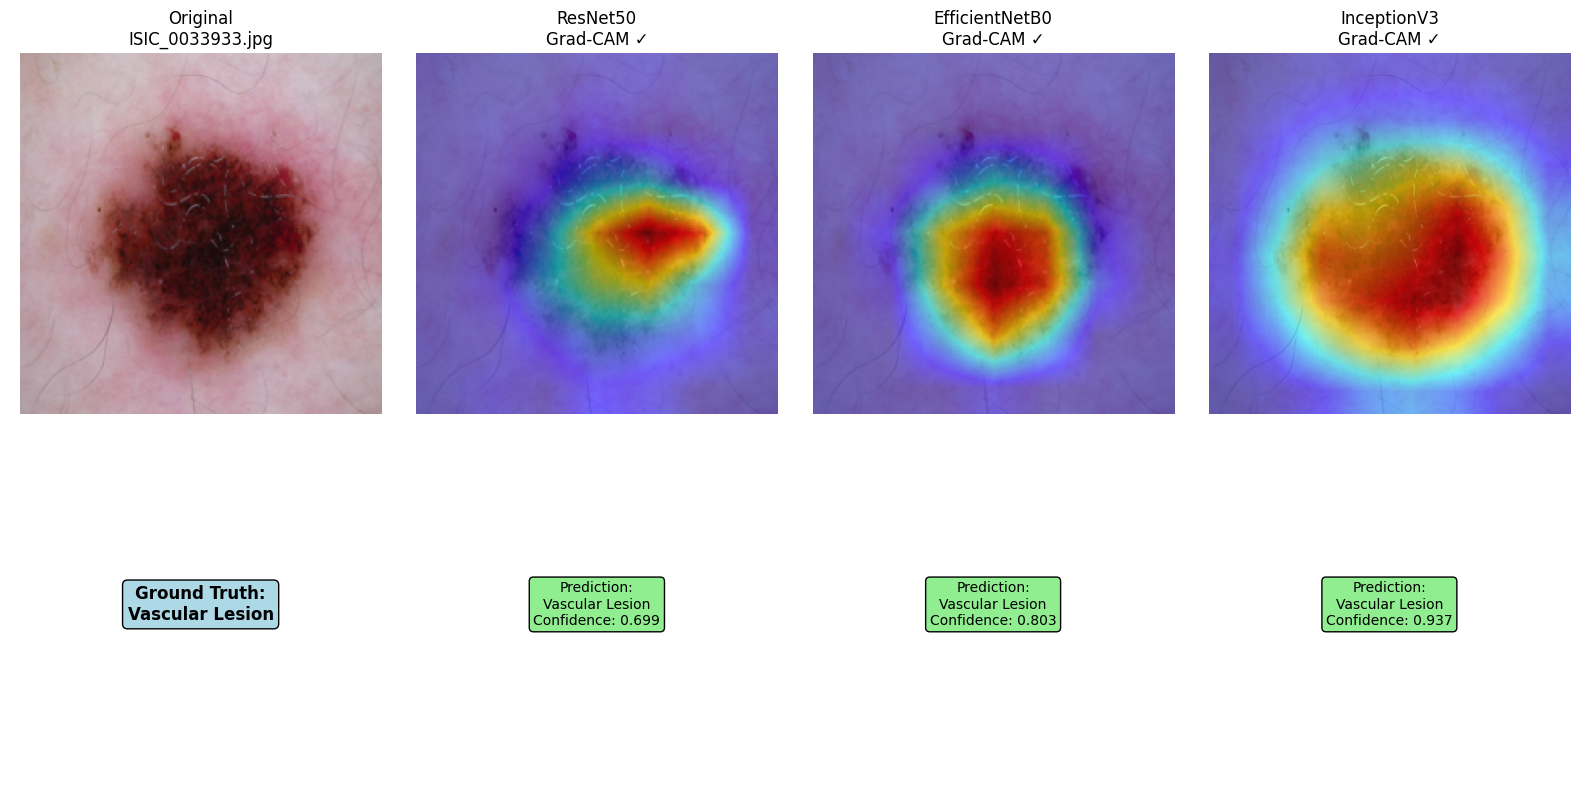


Image 4/10: ISIC_0025580.jpg
Ground Truth: Vascular Lesion
------------------------------
ResNet50       : Vascular Lesion      (1.000) ✓ CORRECT
EfficientNetB0 : Vascular Lesion      (1.000) ✓ CORRECT
InceptionV3    : Vascular Lesion      (1.000) ✓ CORRECT
Ensemble       : Vascular Lesion      (1.000) ✓ CORRECT


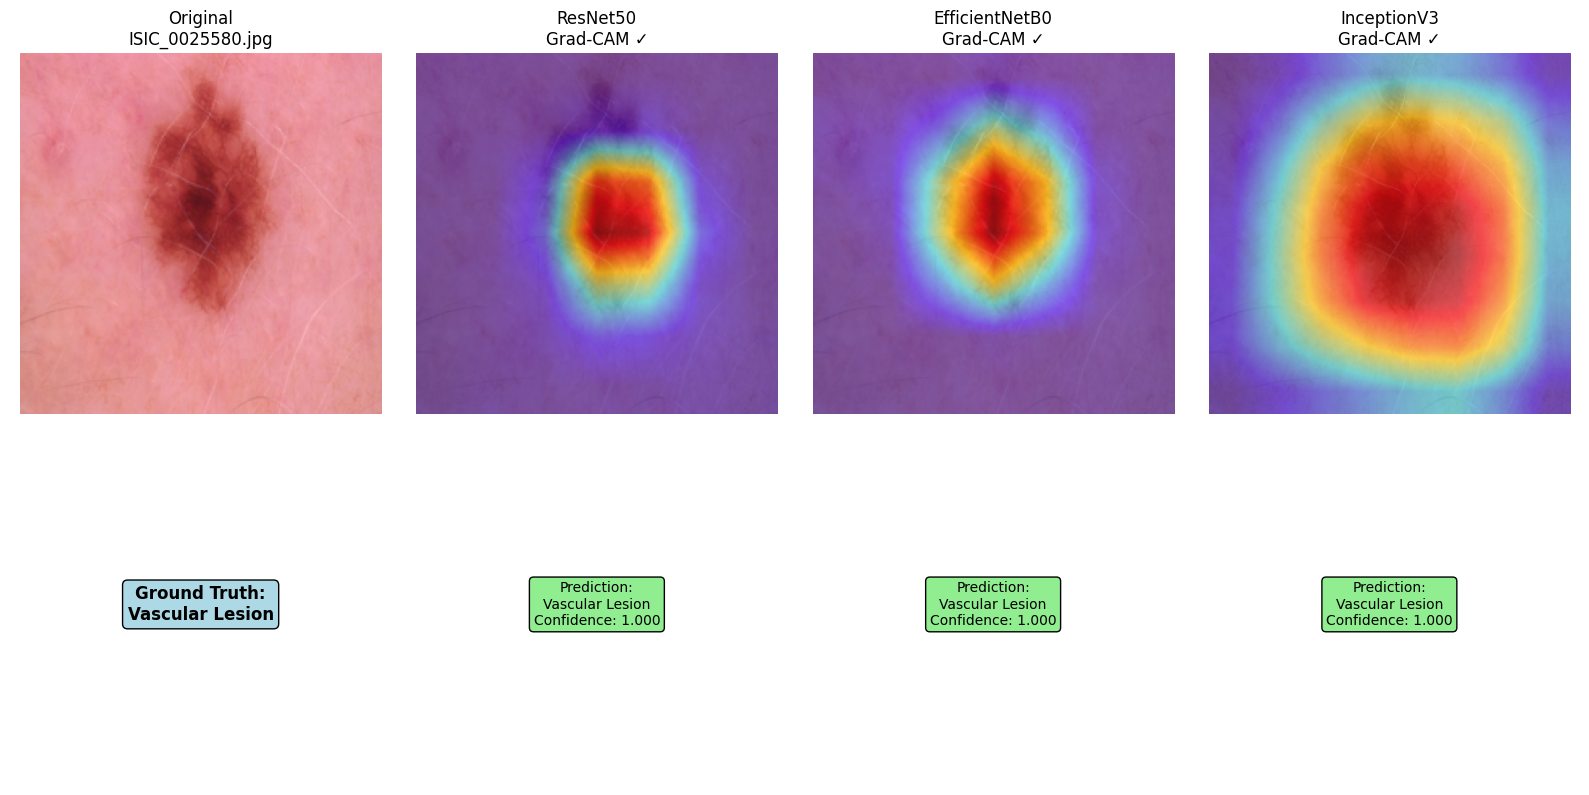


Image 5/10: ISIC_0029773.jpg
Ground Truth: Vascular Lesion
------------------------------
ResNet50       : Vascular Lesion      (0.824) ✓ CORRECT
EfficientNetB0 : Vascular Lesion      (0.745) ✓ CORRECT
InceptionV3    : Vascular Lesion      (0.554) ✓ CORRECT
Ensemble       : Vascular Lesion      (0.523) ✓ CORRECT


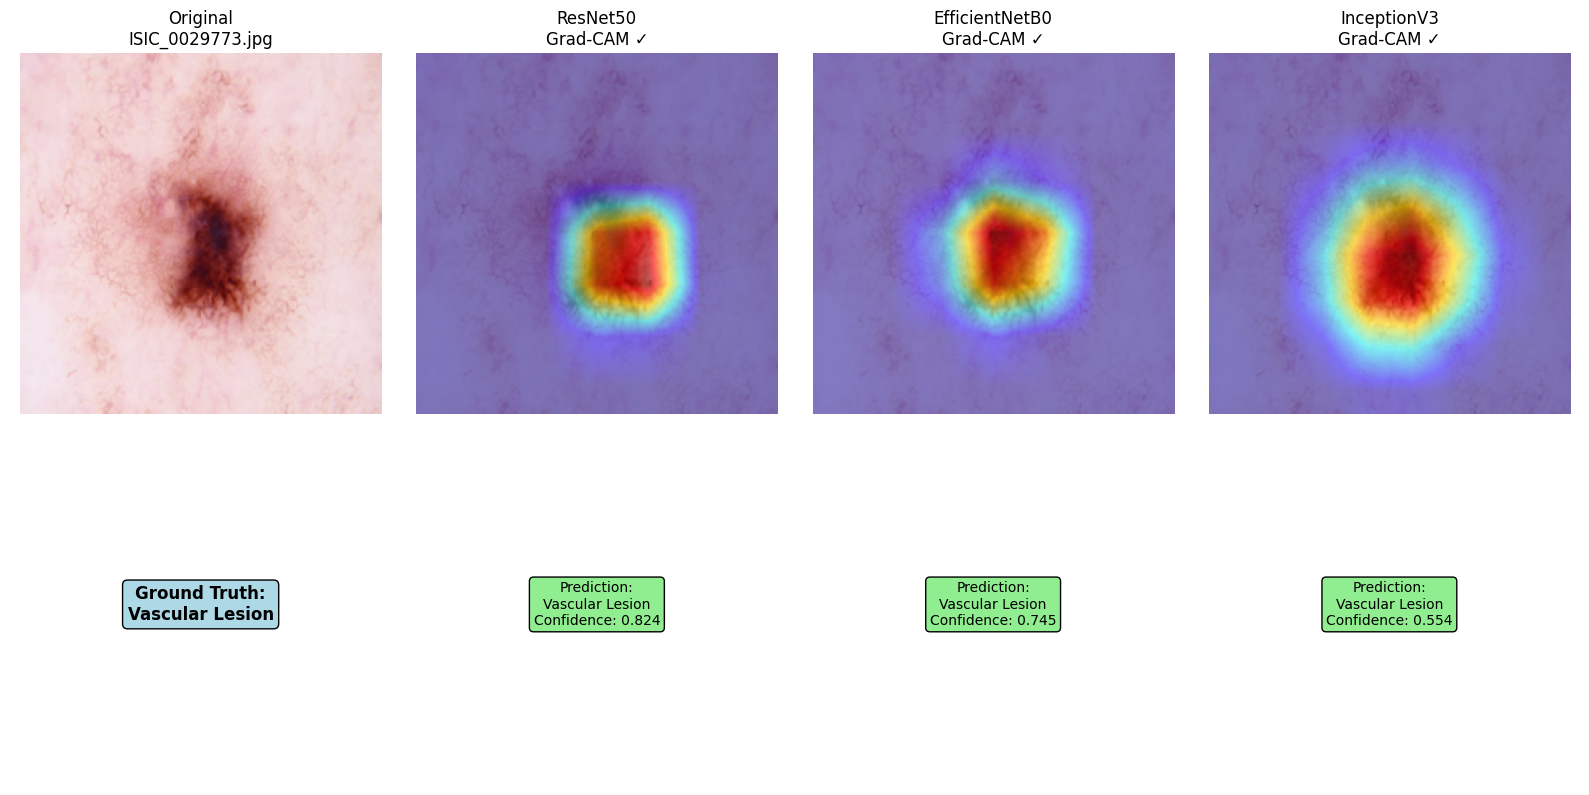


Image 6/10: ISIC_0024600.jpg
Ground Truth: Vascular Lesion
------------------------------
ResNet50       : Vascular Lesion      (0.996) ✓ CORRECT
EfficientNetB0 : Vascular Lesion      (0.998) ✓ CORRECT
InceptionV3    : Vascular Lesion      (1.000) ✓ CORRECT
Ensemble       : Vascular Lesion      (0.971) ✓ CORRECT


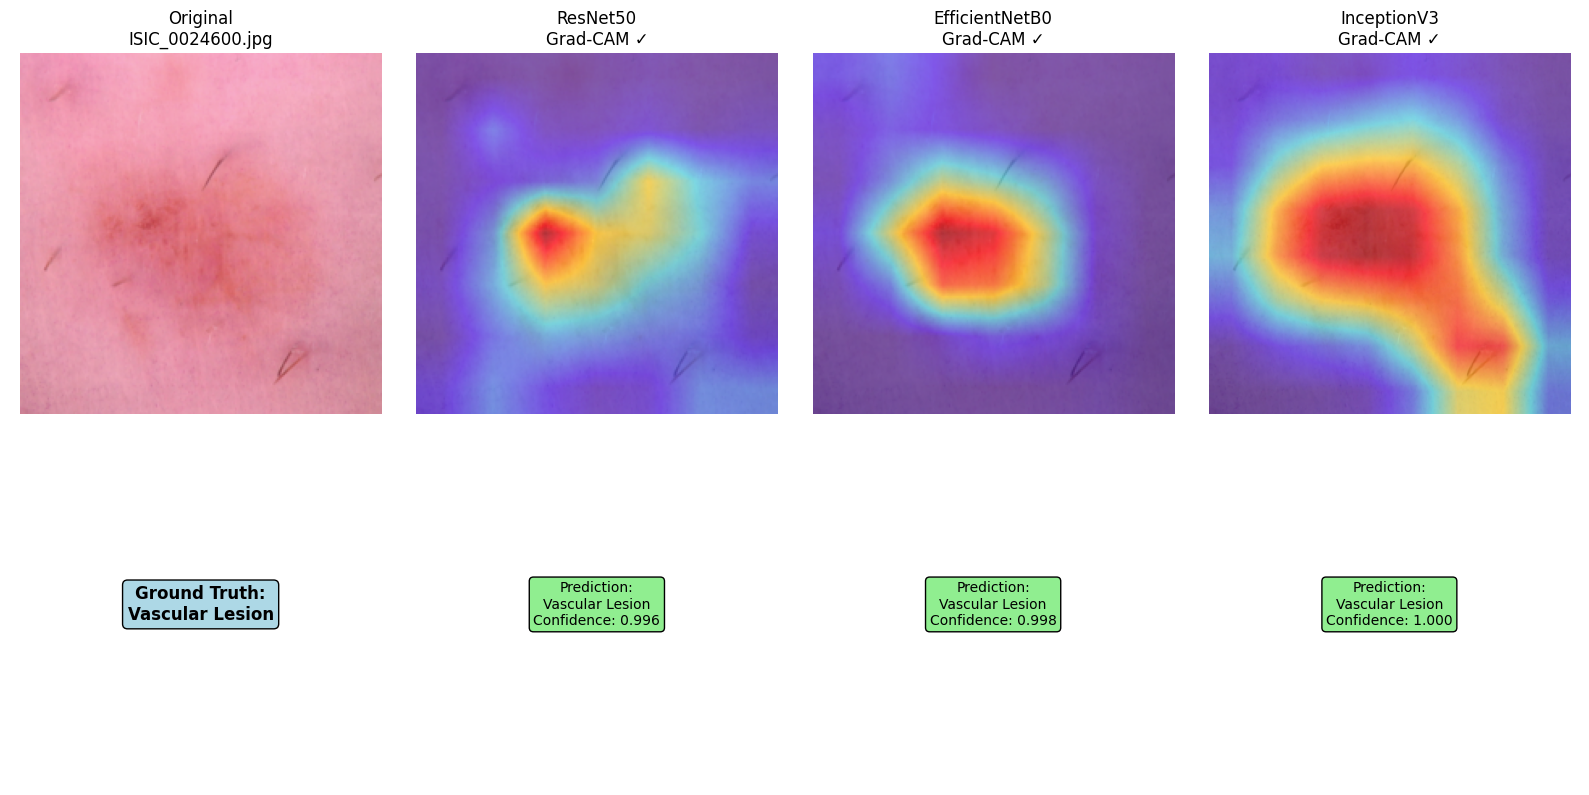


Image 7/10: ISIC_0024487.jpg
Ground Truth: Vascular Lesion
------------------------------
ResNet50       : Vascular Lesion      (1.000) ✓ CORRECT
EfficientNetB0 : Vascular Lesion      (0.989) ✓ CORRECT
InceptionV3    : Vascular Lesion      (1.000) ✓ CORRECT
Ensemble       : Vascular Lesion      (0.996) ✓ CORRECT


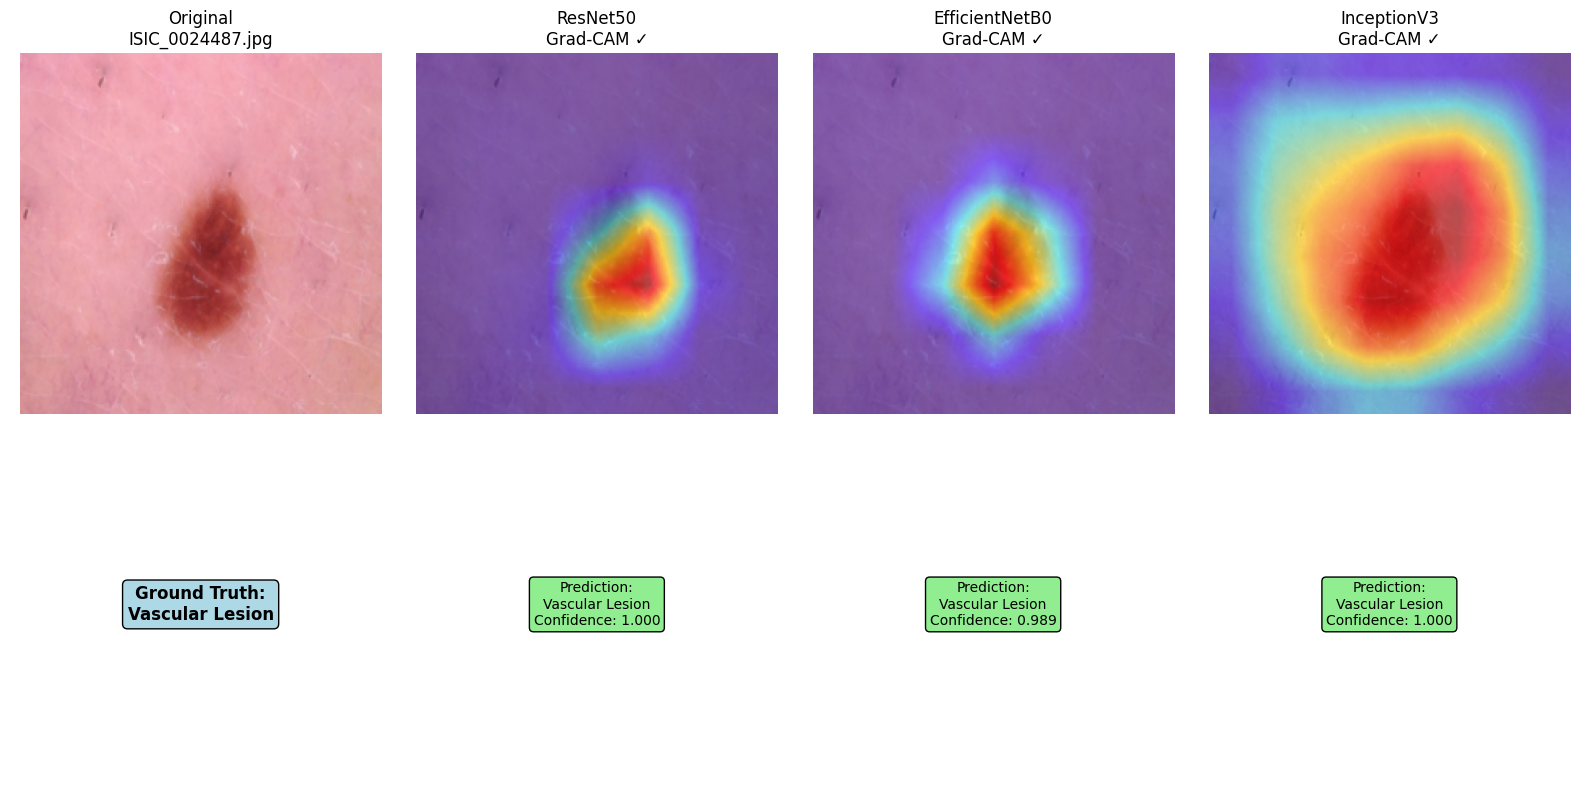


Image 8/10: ISIC_0026663.jpg
Ground Truth: Benign Keratosis
------------------------------
ResNet50       : Benign Keratosis     (0.942) ✓ CORRECT
EfficientNetB0 : Benign Keratosis     (0.783) ✓ CORRECT
InceptionV3    : Benign Keratosis     (0.818) ✓ CORRECT
Ensemble       : Benign Keratosis     (0.843) ✓ CORRECT


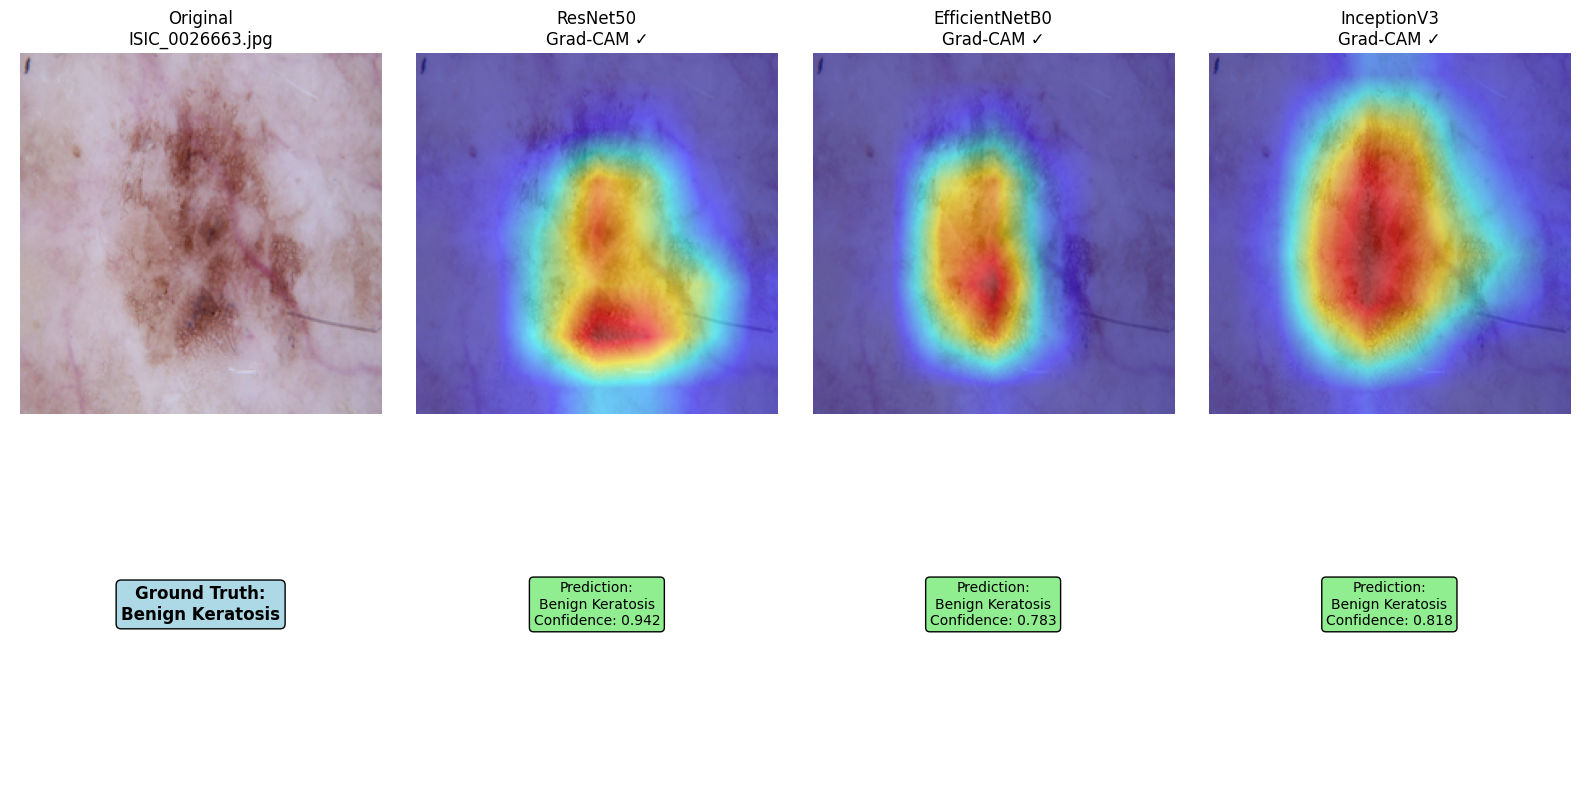


Image 9/10: ISIC_0029877.jpg
Ground Truth: Dermatofibroma
------------------------------
ResNet50       : Vascular Lesion      (0.808) ✗ WRONG
EfficientNetB0 : Vascular Lesion      (0.999) ✗ WRONG
InceptionV3    : Vascular Lesion      (0.974) ✗ WRONG
Ensemble       : Vascular Lesion      (0.743) ✗ WRONG


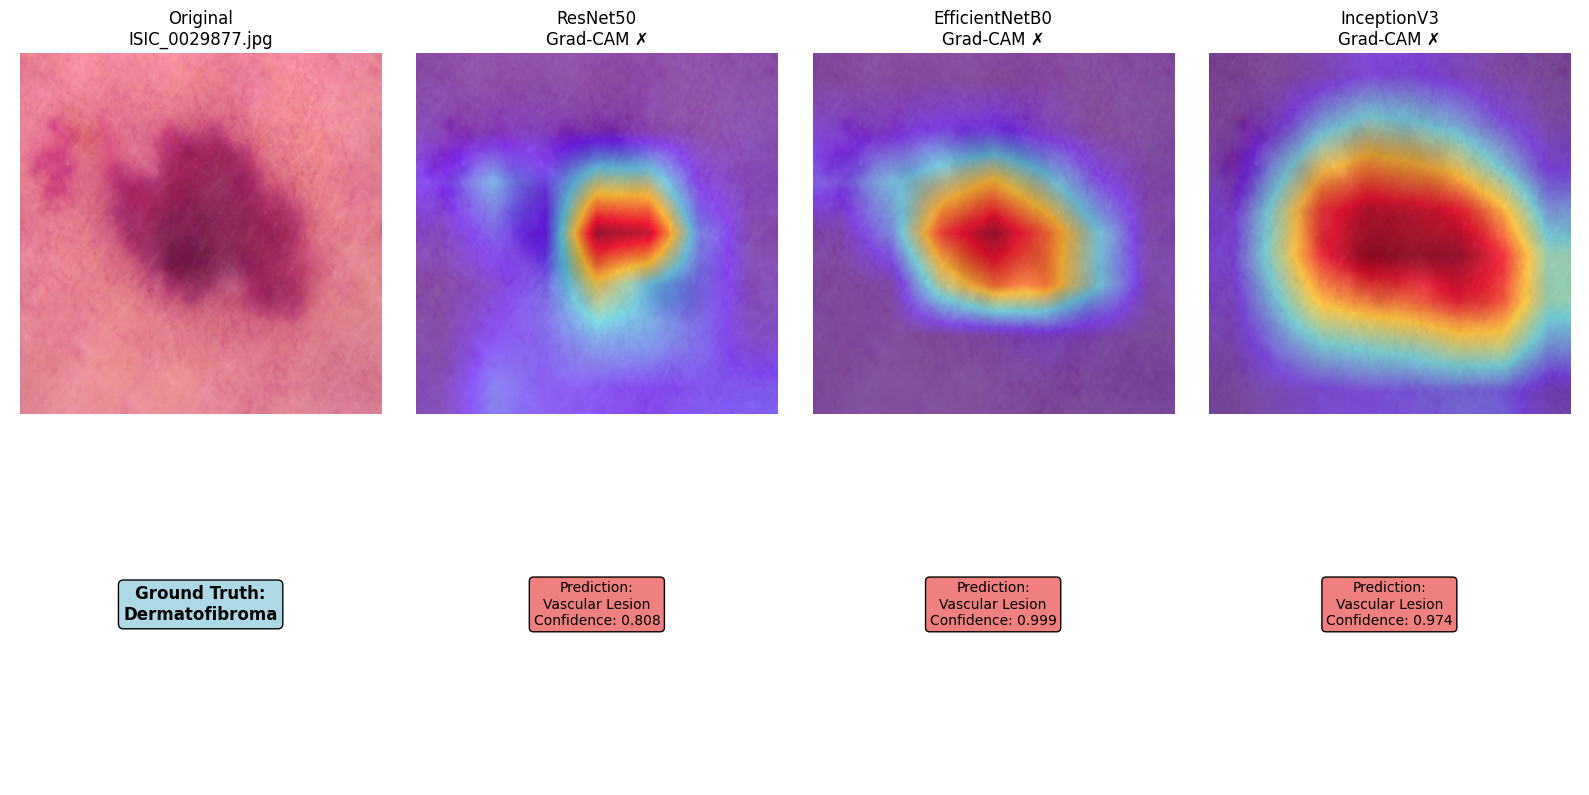


Image 10/10: ISIC_0029290.jpg
Ground Truth: Vascular Lesion
------------------------------
ResNet50       : Vascular Lesion      (1.000) ✓ CORRECT
EfficientNetB0 : Vascular Lesion      (0.953) ✓ CORRECT
InceptionV3    : Vascular Lesion      (0.987) ✓ CORRECT
Ensemble       : Vascular Lesion      (0.984) ✓ CORRECT


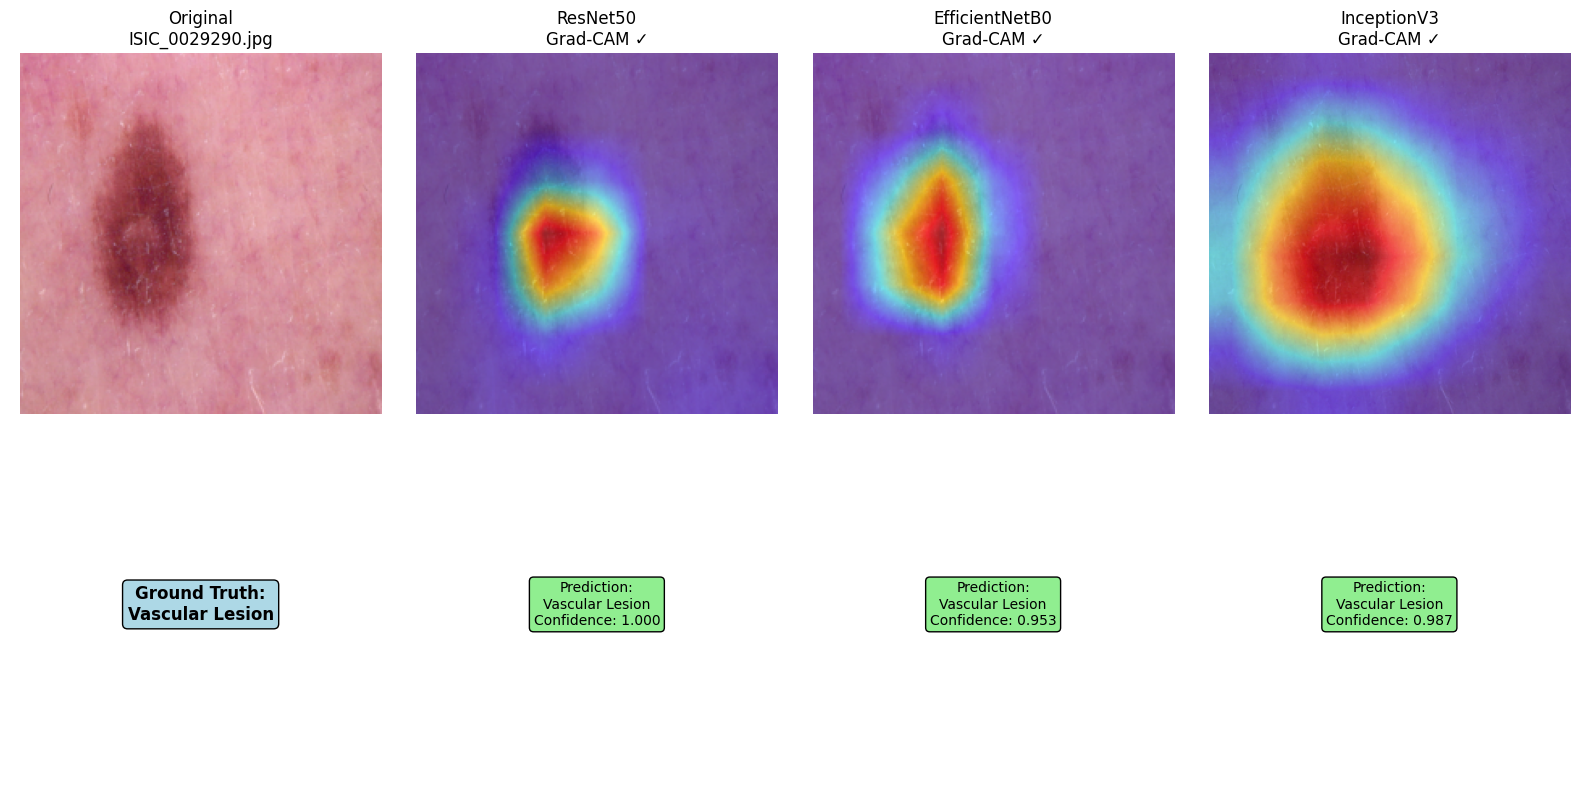


----------------------------------------
COMPREHENSIVE EVALUATION ON FULL TEST SET
----------------------------------------


Evaluating: 100%|██████████| 802/802 [01:15<00:00, 10.61it/s]



COMPREHENSIVE PERFORMANCE METRICS

ResNet50 Performance:
  Accuracy:     80.30%
  Precision:    83.21%
  Recall:       80.30%
  F1-Score:     81.15%
  Avg Conf:     85.83%

EfficientNetB0 Performance:
  Accuracy:     80.05%
  Precision:    82.40%
  Recall:       80.05%
  F1-Score:     80.85%
  Avg Conf:     84.27%

InceptionV3 Performance:
  Accuracy:     80.55%
  Precision:    81.93%
  Recall:       80.55%
  F1-Score:     80.82%
  Avg Conf:     89.14%

Ensemble Performance:
  Accuracy:     82.17%
  Precision:    83.81%
  Recall:       82.17%
  F1-Score:     82.59%
  Avg Conf:     81.00%


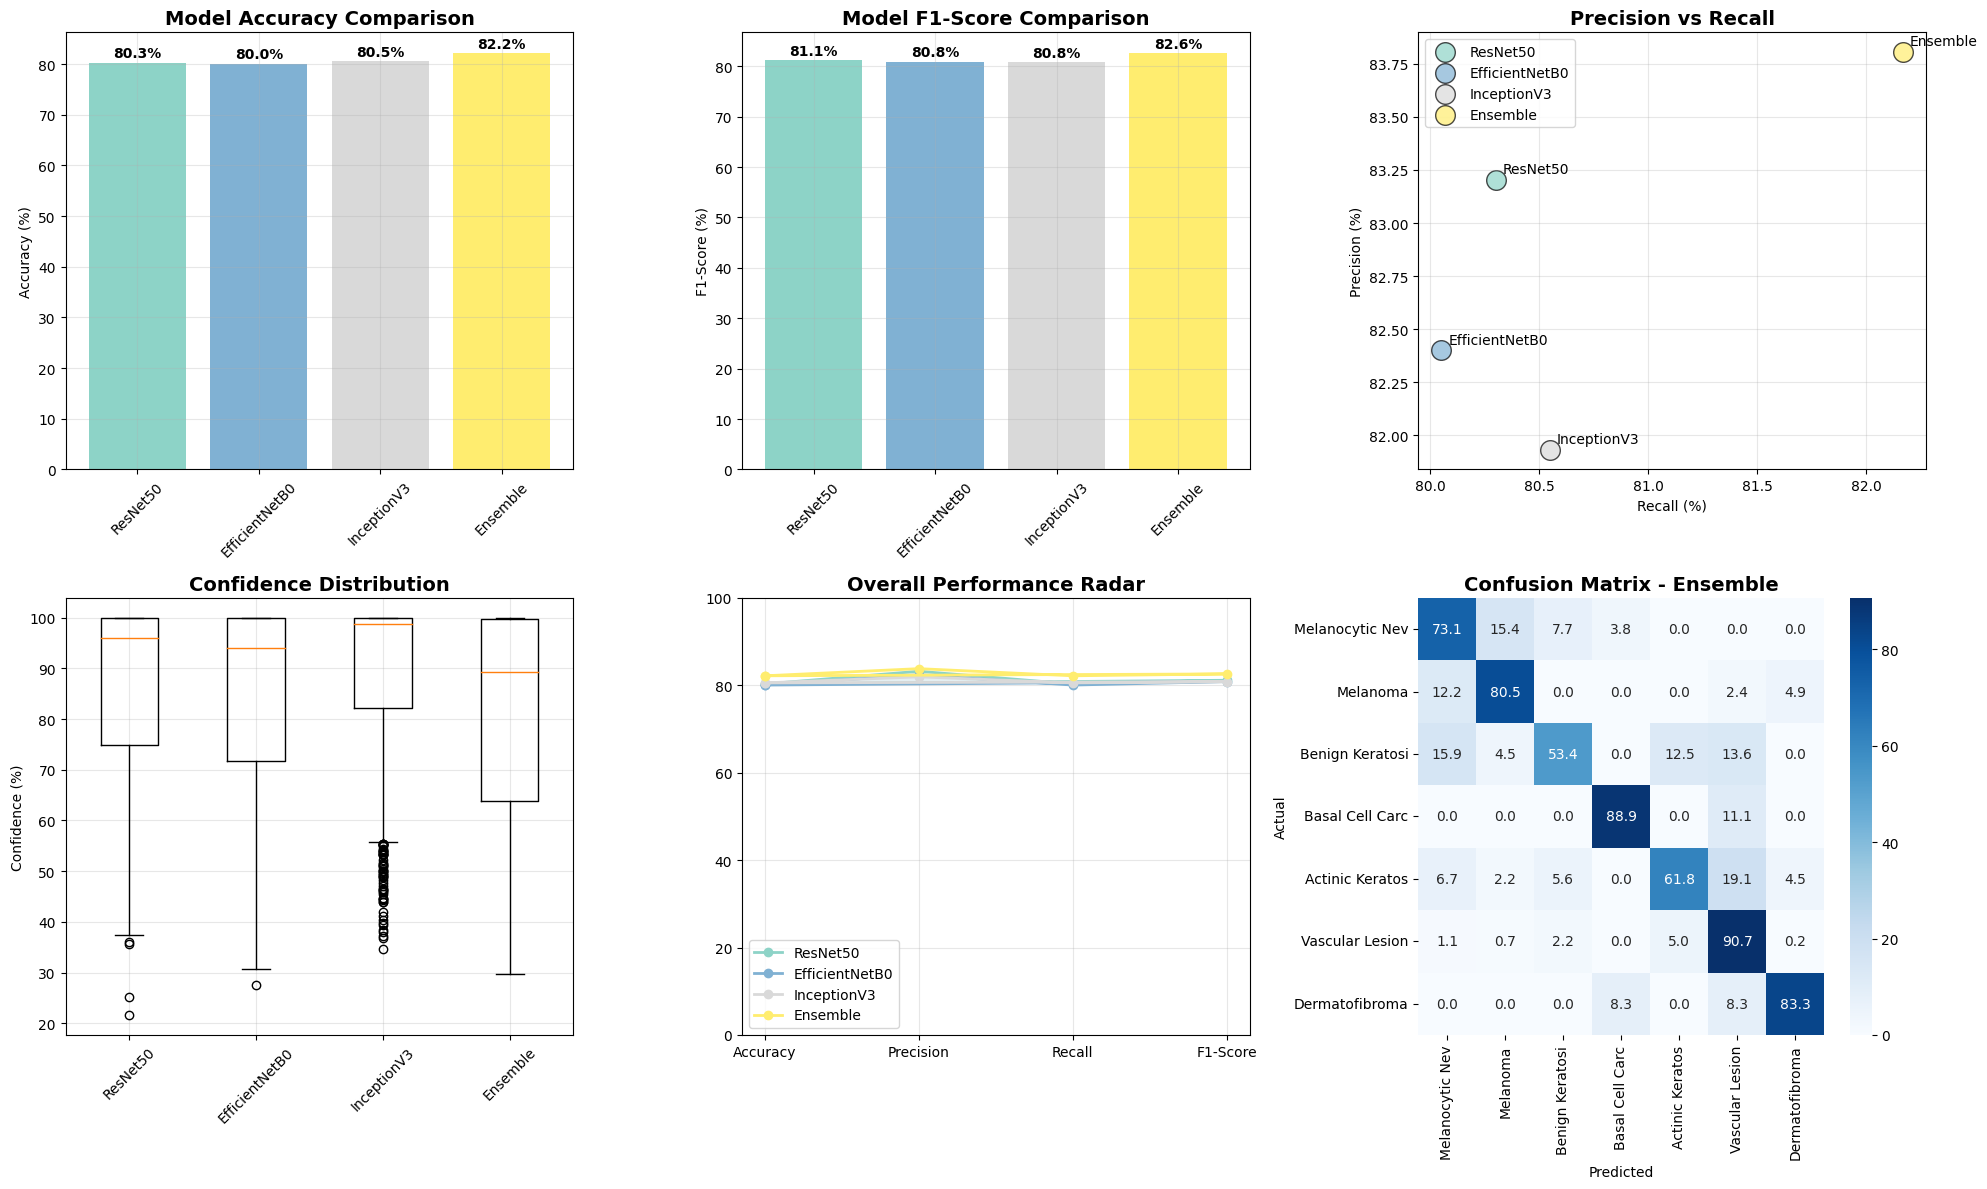


DETAILED CLASSIFICATION REPORT - BEST MODEL (Ensemble)
                      precision    recall  f1-score   support

   Melanocytic Nevus      0.380     0.731     0.500        26
            Melanoma      0.702     0.805     0.750        41
    Benign Keratosis      0.712     0.534     0.610        88
Basal Cell Carcinoma      0.800     0.889     0.842         9
   Actinic Keratoses      0.591     0.618     0.604        89
     Vascular Lesion      0.938     0.907     0.922       537
      Dermatofibroma      0.588     0.833     0.690        12

            accuracy                          0.822       802
           macro avg      0.673     0.760     0.703       802
        weighted avg      0.838     0.822     0.826       802


FINAL PERFORMANCE SUMMARY
Model           Accuracy   Precision   Recall   F1-Score  Avg Conf 
--------------------------------------------------------------------------------
ResNet50        80.30      83.21       80.30    81.15     85.83    
EfficientNetB0 

In [20]:
# Main execution function
def run_complete_evaluation():
    """Run the complete training and evaluation pipeline"""
    
    print("Starting complete SkinScanAI evaluation pipeline...")
    
    # Step 1: Train models
    print("Step 1: Training models for 5 epochs...")
    training_results, test_df = train_and_save_improved_models()
    
    # Step 2: Comprehensive evaluation
    print("\nStep 2: Running comprehensive evaluation...")
    evaluation_results, detailed_results = comprehensive_model_evaluation(
        test_df=test_df, 
        num_random_images=10, 
        show_gradcam=True
    )
    
    # Step 3: Training vs Testing comparison
    print("\n" + "="*80)
    print("TRAINING VS TESTING COMPARISON")
    print("="*80)
    
    print(f"{'Model':<15} {'Train Val Acc':<15} {'Test Accuracy':<15} {'Difference':<12}")
    print("-" * 70)
    
    for model_name in training_results.keys():
        if model_name in evaluation_results:
            train_acc = training_results[model_name]['best_val_acc']
            test_acc = evaluation_results[model_name]['accuracy']
            difference = test_acc - train_acc
            
            print(f"{model_name:<15} {train_acc:<15.2f} {test_acc:<15.2f} {difference:<12.2f}")
    
    print("\nEvaluation complete!")
    return training_results, evaluation_results, detailed_results

# Execute the complete pipeline
if __name__ == "__main__":
    training_results, evaluation_results, detailed_results = run_complete_evaluation()